# SD201 : MINING OF LARGE DATASETS

## MUSIC GENRE CLASSIFICATION USING SONG LYRICS

In [32]:
# initial imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

from langdetect import detect

### 1. CONSTRUCTION OF THE DATASET

The source of the dataset is a csv file : a result of a scrapping work through [GENIUS](https://genius.com/).

#### 1.1 RAW DATA EXPLORATION

In [33]:
# loading the dataset from csv file
data = pd.read_csv("lyrics.csv", sep='#')

In [34]:
# columns of dataset
data.columns

Index(['artist', 'title', 'lyrics', 'genre', 'url'], dtype='object')

In [35]:
# inspecting the content of the dataset
data.head()

,artist,title,lyrics,genre,url
0,Eminem,Rap God,"Rap God Lyrics\r\n""Look, I was gonna go easy o...",rap,https://genius.com/Eminem-rap-god-lyrics
1,Cardi B,WAP,WAP Lyrics\r\nWhores in this house\r\nThere's ...,rap,https://genius.com/Cardi-b-wap-lyrics
2,Kendrick Lamar,HUMBLE.,HUMBLE. Lyrics\r\nNobody pray for me\r\nIt bee...,rap,https://genius.com/Kendrick-lamar-humble-lyrics
3,Migos,Bad and Boujee,"Bad and Boujee Lyrics\r\nYou know, young rich ...",rap,https://genius.com/Migos-bad-and-boujee-lyrics
4,Drake,God's Plan,God’s Plan Lyrics\r\nAnd they wishin' and wish...,rap,https://genius.com/Drake-gods-plan-lyrics


In [36]:
# size of the dataset
data.shape

(6858, 5)

In [37]:
# types of data 
data.dtypes

artist    object
title     object
lyrics    object
genre     object
url       object
dtype: object

#### 1.2 RAW DATA CLEANING

In [38]:
# Removing unwanted columns
data = data.drop(columns = ['artist','title','url'])

In [39]:
#Missing values
data.isna().sum()[data.isna().sum() > 0]

lyrics    25
dtype: int64

In [40]:
# Deleting rows with missing values
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [41]:
#Check missing values (check is dropping went right)
data.isna().sum()


lyrics    0
genre     0
dtype: int64

In [42]:
#deleting the "[title]-Lyrics" from the beginning of each lyrics and "[number xxx]Embed" from the end and the non-english lyrics

for i in range(len(data['lyrics'])):
    if(detect(data['lyrics'][i]) != 'en'):
        data.drop([i])

    if(re.findall(r'\d+.*Embed.*', data['lyrics'][i])!=[]):
        data['lyrics'][i] = data['lyrics'][i].split(re.findall(r'\d+.*Embed.*', data['lyrics'][i])[0])[0]

    if (re.findall(r'\bLyrics\b', data['lyrics'][i])!=[]):
        data['lyrics'][i] = data['lyrics'][i].split('Lyrics')[1]
    data['lyrics'][i] = data['lyrics'][i].lower()

In [43]:
#Checking the data cleaning on a random song lyrics
print(data['lyrics'][1])


whores in this house
there's some whores in this house
there's some whores in this house
there's some whores in this house (hol' up)
i said certified freak, seven days a week
wet-ass pussy, make that pullout game weak, woo (ah)

yeah, yeah, yeah, yeah
yeah, you fuckin' with some wet-ass pussy
bring a bucket and a mop for this wet-ass pussy
give me everything you got for this wet-ass pussy

beat it up, nigga, catch a charge
extra large and extra hard
put this pussy right in your face
swipe your nose like a credit card
hop on top, i wanna ride
i do a kegel while it's inside
spit in my mouth, look in my eyes
this pussy is wet, come take a dive
tie me up like i'm surprised
let's roleplay, i'll wear a disguise
i want you to park that big mack truck right in this little garage
make it cream, make me scream
out in public, make a scene
i don't cook, i don't clean
but let me tell you how i got this ring (ayy, ayy)
you might also like
gobble me, swallow me, drip down the side of me (yeah)
quick

In [44]:
# Common repeated words by genre
for the_genre in data.genre.unique():
    print(the_genre)
    print(data.loc[data['genre'] == the_genre].lyrics.str.split(expand=True).stack().value_counts()[0:10])

rap
i      22876
the    21078
you    17272
a      13159
and    10561
my     10372
to     10145
in      7595
i'm     7587
me      7367
dtype: int64
hip-hop
the    24322
i      22628
you    17415
a      14681
to     13017
and    12831
my     10654
in      8422
i'm     8143
me      7899
dtype: int64
country
i      1600
you    1409
the    1300
and    1042
a       810
to      712
me      536
it      517
in      494
my      493
dtype: int64
rock
the    10840
i      10444
you    10203
and     6647
to      5817
a       5419
my      4284
me      4026
in      3858
it      3291
dtype: int64
pop
i      11874
you    11518
the     9052
to      5307
and     5302
a       5088
my      4705
me      4471
it      3975
i'm     3579
dtype: int64
r-b
you    19336
i      18199
the    12787
to      8145
me      7346
a       7212
and     7139
my      6979
it      6151
i'm     5389
dtype: int64
metal
the    12449
you     8058
i       7319
to      5531
and     5063
a       4784
of      3615
my      3591
in      3

In [45]:
# Removing punctuation and stopwords from lyrics

from nltk import word_tokenize

from nltk.corpus import stopwords


#stopwords = stopwords.words('english')
stopwords = ["'d","'m","'s","'ve","'re","'ll","'cause","'bout", 
             "a", "able", "about", "above", "across", "actually", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "all", "almost", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "an", "and", "any", "anybody", "anyhow",  "apart", "are", "aren", "arent", "aren't", "around", "as", "at",  "aw", "away",
             "b", "back", "be" , "became", "because", "become", "becomes", "becoming", "been", "before", "behind", "being", "below", "beside", "besides", "best", "better", "between", "beyond","both", "bottom", "but", "by", 
             "c", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch",  "cit", "clearly", "c'mon", "cn", "co", "com", "come", "comes","could", "couldn", "couldnt", "couldn't", "currently", 
             "d", "date", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "do", "does", "doesn", "doesn't", "doing","doin'", "don", "done", "don't", "down", "due", "during", 
             "e", "each", "ei", "eight", "eighty", "either", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "especially",  "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly",  "except", "ey", 
             "f", "far", "fc", "few", "fifteen", "fifth", "fify", "fill", "first", "five", "fix", "fo", "for", "former", "formerly", "forth", "forty", "found", "four",  "from", "front", "fu", "full", "further", "furthermore",
             "g", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "go", "goes", "going","goin'", "gon" ,"gon'" , "gonna" , "gone", "got", "gotten", "gr", 
             "h", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll",  "her", "here", "heres", "here's", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his",  "ho",  "how",  "however", "how's", 
             "i", "ia", "i'd", "if", "ignored", "ih", "ii", "i'll", "im", "i'm", "in", "inc", "indeed",  "inner", "instead", "into", "is", "isn", "isn't", "it", "it'd", "it'll", "its", "it's", "itself", "iv", "i've",
             "j", "just", 
             "k", "ke", "keep", "keeps", "kept","know", "known", "knows", "ko", 
             "l", "la","ll", "last", "lately", "later", "latter", "latterly", "least", "les", "less", "lest", "let", "lets", "let's", "like", "liked", "likely", "line", "little", "ll", "look", "looking", "looks", "los", 
             "m", "ma", "made", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms","much", "mug", "must", "mustn", "mustn't", "my", "myself", 
             "n", "n't", "na", "name", "near", "nearly", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nn", "no", "nobody", "non", "none", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere",  
             "o", "oa", "obviously", "of" , "off", "often", "oh" , "ooh" , "ok", "okay","old",  "on", "once", "one", "ones", "only", "onto", "oo", "or", "other", "others", "otherwise", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", 
             "p","part", "perhaps", "probably", 
             "q", "quickly", "quite", 
             "r", "rather", "readily", "really", "right", "run",
             "s", "sa", "said", "same", "saw", "say", "saying", "says", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty","so" , "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere","still",  "such", 
             "t", "take", "taken", "taking","to","tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there","there's", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "together", "too", "took", "top", "toward", "towards",  "truly",  "twelve", "twenty", "twice", "two",  
             "u", "uh", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", 
             "v", "va","very",
             "w", "wa", "want", "wanna" , "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", 
             "x", "xo",
             "y", "yes", "yet", "yeah" , "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", 
             "z", "zero"]

data['lyrics'] = data['lyrics'].str.replace("[-\?.,\/#!$%\^&\*;:{}=\_~()\`]", ' ')
data['lyrics'] = data['lyrics'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))



C:\Users\louiz\AppData\Local\Temp\ipykernel_8716\4077513555.py:37: FutureWarning: The default value of regex will change from True to False in a future version.
  data['lyrics'] = data['lyrics'].str.replace("[-\?.,\/#!$%\^&\*;:{}=\_~()\`]", ' ')


In [46]:
# After cleaning : Checking Common repeated words by genre
for the_genre in data.genre.unique():
    print(the_genre)
    print(data.loc[data['genre'] == the_genre].lyrics.str.split(expand=True).stack().value_counts()[0:10])

rap
nigga     2819
fuck      2458
bitch     2405
shit      2382
niggas    2037
love      2025
man       1345
ayy       1343
baby      1339
time      1217
dtype: int64
hip-hop
shit      2382
fuck      2121
nigga     1935
bitch     1928
love      1754
niggas    1557
time      1540
man       1410
'em       1393
baby      1227
dtype: int64
country
love        186
time        135
man          88
baby         75
home         67
remember     65
feel         65
long         59
red          59
day          57
dtype: int64
rock
love     1480
time      912
hey       749
feel      628
baby      619
life      498
da        498
heart     468
man       463
day       411
dtype: int64
pop
love     2129
baby     1212
time      803
feel      750
hey       640
girl      633
night     621
good      548
life      475
ayy       403
dtype: int64
r-b
love     3452
baby     2335
girl     1692
time     1355
feel     1120
shit      940
night     887
life      879
fuck      853
hey       842
dtype: int64
metal
fuc

In [47]:
# Lemmatize lyrics = reduce words (“stay” from “staying”)
import nltk

from nltk.stem import WordNetLemmatizer

def lemmatize_lyrics(lyrics):
    # lyrics to list of words
    lyrics_tokens = lyrics.split()

    # lemmatizing every token of every song lyrics
    lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
    lyrics_tokens = [lemmatizer.lemmatize(token) for token in lyrics_tokens]
        
    # joining tokens together 
    cleaned_lyrics = " ".join(lyrics_tokens)
    return cleaned_lyrics


In [48]:
data["lyrics"]  = data["lyrics"].apply(lambda x:  lemmatize_lyrics(x))

In [49]:
# After lemmatizing : Checking Common repeated words by genre
for the_genre in data.genre.unique():
    print(the_genre)
    print(data.loc[data['genre'] == the_genre].lyrics.str.split(expand=True).stack().value_counts()[0:10])

rap
nigga    4856
bitch    3104
fuck     2476
shit     2420
love     2047
time     1405
man      1368
baby     1366
girl     1349
ayy      1343
dtype: int64
hip-hop
nigga    3492
bitch    2431
shit     2400
fuck     2139
love     1809
time     1750
man      1455
'em      1393
baby     1281
girl     1128
dtype: int64
country
love        192
time        148
man          88
day          83
girl         80
thing        77
feel         75
baby         75
home         67
remember     65
dtype: int64
rock
love     1508
time     1083
hey       749
feel      717
baby      620
life      548
day       547
heart     518
da        504
night     465
dtype: int64
pop
love     2151
baby     1223
time      909
feel      870
girl      819
night     696
hey       640
good      548
bitch     512
life      511
dtype: int64
r-b
love     3510
baby     2350
girl     1958
time     1551
feel     1275
nigga    1172
night     994
shit      949
life      922
fuck      867
dtype: int64
metal
fuck      1066
time    

#### 1.3 CLEANED RAW DATA VISUALISATION

Number of songs grouped by genre of music: genre
country     119
hip-hop    1000
jazz        979
metal       996
pop         739
r-b        1000
rap        1000
rock       1000
Name: lyrics, dtype: int64


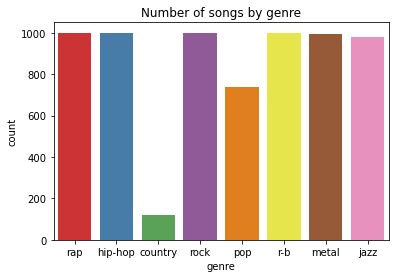

In [50]:
print("Number of songs grouped by genre of music:",data.groupby('genre').count()['lyrics'])
ax = plt.subplots()
ax = sns.countplot(x="genre", data = data, palette= "Set1")
ax.set_title("Number of songs by genre")
plt.show()

**Word clouds by genre:**

In [51]:
data_genre = data.genre.unique()

In [52]:
data_classified = []
for genre_lyrics in data_genre:
    lyrics_list = []
    for i in range(len(data.lyrics) ):
        if (data.genre[i]==genre_lyrics):
            lyrics_list.append(data.lyrics[i])
    data_classified.append(lyrics_list)

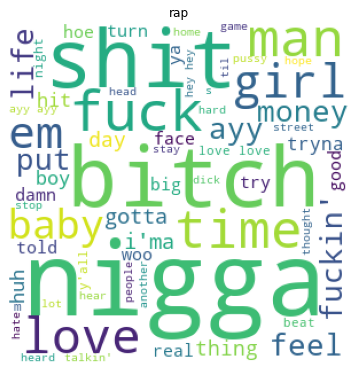

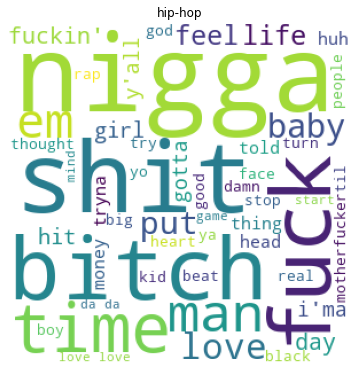

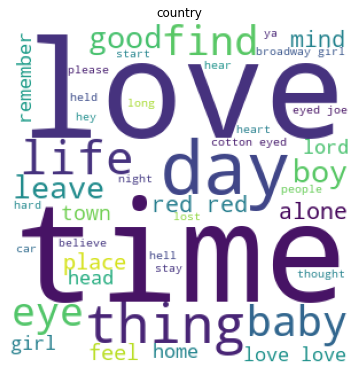

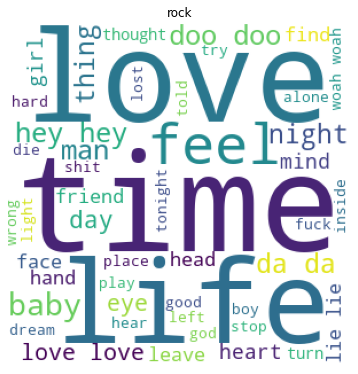

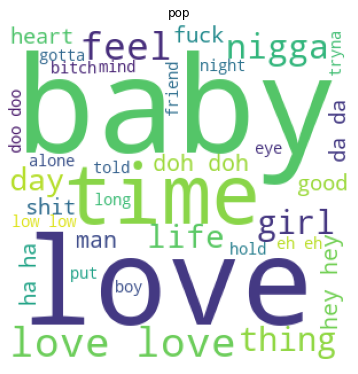

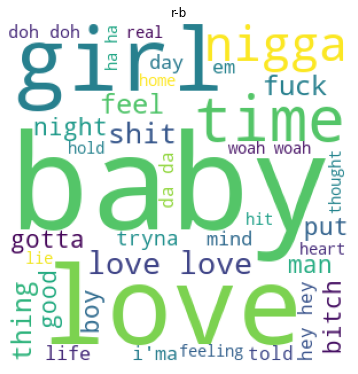

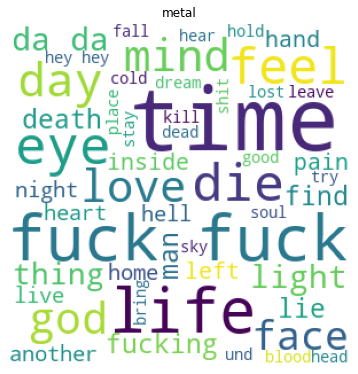

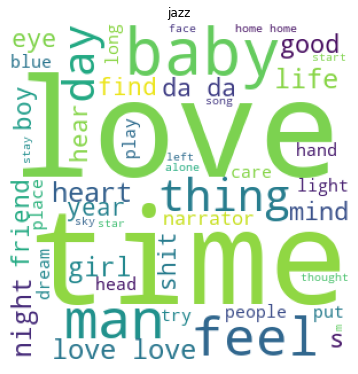

In [53]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

index_genre = 0 
#iterate through every music genre
for lyrics_of_genre in data_classified :

    wordcloud = WordCloud(width = 300, height = 300,background_color ='white', min_font_size = 10).generate(" ".join(lyrics_of_genre)+" ")
 
    # plot the WordCloud                       
    plt.figure(figsize = (5, 5), facecolor = None)
    plt.imshow(wordcloud)
    plt.title(data_genre[index_genre])
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
    # Save the image in the img folder:
    #wordcloud.to_file("img"+data_genre[index_genre]+"_words.png")
    index_genre +=1

### 2. DATA MODELING

In [54]:
#imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.tokenize import RegexpTokenizer


In [55]:
# Selecting the columns for training
y = data.genre.values
#x = data.lyrics.values 

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(ngram_range = (1,1),tokenizer = token.tokenize)
x= cv.fit_transform(data['lyrics'])

In [68]:
print(x)

  (0, 23384)	1
  (0, 12047)	1
  (0, 18712)	1
  (0, 13975)	1
  (0, 5848)	1
  (0, 6739)	1
  (0, 25595)	2
  (0, 37234)	2
  (0, 34268)	8
  (0, 44410)	1
  (0, 13971)	5
  (0, 20094)	1
  (0, 25593)	1
  (0, 36794)	2
  (0, 35721)	1
  (0, 20832)	1
  (0, 13974)	1
  (0, 17348)	1
  (0, 41223)	2
  (0, 4225)	3
  (0, 3316)	1
  (0, 6743)	1
  (0, 44923)	1
  (0, 11182)	2
  (0, 28520)	1
  :	:
  (6831, 1074)	2
  (6831, 23815)	1
  (6831, 4906)	2
  (6832, 40356)	6
  (6832, 23484)	1
  (6832, 9681)	1
  (6832, 16362)	1
  (6832, 40092)	1
  (6832, 22593)	1
  (6832, 44933)	1
  (6832, 17640)	2
  (6832, 17649)	1
  (6832, 23567)	3
  (6832, 44706)	1
  (6832, 23508)	2
  (6832, 8485)	1
  (6832, 13247)	1
  (6832, 29421)	1
  (6832, 44955)	1
  (6832, 42151)	1
  (6832, 20155)	1
  (6832, 22928)	1
  (6832, 23862)	1
  (6832, 44954)	1
  (6832, 44930)	1


In [56]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [76]:
from sklearn.naive_bayes import BernoulliNB,MultinomialNB

print ("Bernoulli naive bayes: %s"%(BernoulliNB().fit(x_train,y_train).score(x_test,y_test)))
print ("Multinomial naive bayes: %s"%(MultinomialNB().fit(x_train,y_train).score(x_test,y_test)))


Bernoulli naive bayes: 0.44330651060716897
Multinomial naive bayes: 0.39063643013899046


### 3. Other approaches